In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
# import visual tools
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import seaborn as sns

plt.style.use('seaborn-talk')
plt.style.use('bmh')
#plt.rcParams['font.family'] = 'DejaVu Sans Mono'
plt.rcParams['font.size'] = 9.5
plt.rcParams['font.weight'] = 'medium'
plt.rcParams['figure.figsize'] = 10,7
blue, green, red, purple, gold, teal = sns.color_palette('colorblind', 6)

In [3]:
from tqdm import tqdm, tqdm_notebook
import warnings
warnings.filterwarnings("ignore")
import missingno as msno

In [ ]:
# from src.utils.utils import *
# import src.features.bars as brs
# import src.features.snippets as snp

RANDOM_STATE = 777

In [76]:
data_dir = "../indices/"
data_dir = "../indices_daily/"

In [467]:
def create__data_set(raw_link,frq):
    infp = raw_link
    _data_= pd.read_csv(infp)#[['Date','Price']]
    _data_= _data_.rename(columns={"Price":"price","Vol.":"volume","Date":'time_stamp'})
    _data_=_data_[['time_stamp',"price","volume"]].copy()
    _data_["volume"][_data_["volume"]=="-"]="0K"
    _data_["mult"] = 0
    _data_["mult"][_data_["volume"].str.contains("K")] = 1000
    _data_["mult"][_data_["volume"].str.contains("M")] = 1000000
    _data_["volume"] = _data_["volume"].str.replace('K',"")
    _data_["volume"] = _data_["volume"].str.replace('M',"")
    _data_["volume"]= _data_["volume"].apply(pd.to_numeric)
    _data_["volume"] = _data_["volume"]*_data_["mult"]
    del _data_["mult"]

    _data_['dollar_transaction'] = _data_['price'] * _data_['volume']
    _data_=_data_.sort_values(by=['time_stamp'],ascending=[True])
    _data_['time_stamp'] = pd.to_datetime(_data_['time_stamp'])
    data.index = _data_['time_stamp']

    _data_= _data_.resample(frq).agg({"price":'ohlc',"volume":'sum','dollar_transaction':'sum'})
    _data_.columns = _data_.columns.droplevel()
    #_data_= _data_[['close','volume','transaction']].rename(columns={'close':'price','volume':'v','transaction':'dv'})
    _data_= _data_[['close','volume','dollar_transaction']]#.rename(columns={'close':'price','volume':'v','transaction':'dv'})
    _data_['time_stamp'] = _data_.index
    _data_= _data_.fillna(method='ffill')
    return _data_

def create_bar(dataframe, column_, units,vwap=False,price='close', volume ='volume',dollar_transaction='dollar_transaction'):
    #print(column_)
    _bars_ = dataframe.copy()
    if column_ == 'time_stamp':
        units_=units[0]
        units_frequency=units[1]
        _bars_= _bars_.resample(str(units_)+str(units_frequency), label='right').agg({price:'ohlc',volume:'sum',dollar_transaction:'sum'})
        _bars_.columns = _bars_.columns.droplevel()
        if vwap==True:
            _bars_['vwap'] = _bars_[dollar_transaction]/_bars_[volume]
        
    else:
        if column_ == 'id':
            _bars_[column_] =1

        _bars_['filter'] = _bars_[column_].cumsum()
        _bars_['group']= 0
        n = 0
        _bars_['filter'] = _bars_['filter']/units
        _bars_['filter'] = _bars_['filter'].astype(int)
        _bars_['group']= _bars_['filter']
        _bars_ = _bars_.groupby('group').agg({"time_stamp":"last",price:'ohlc',"volume":'sum','dollar_transaction':'sum'})
        
        _bars_.columns = _bars_.columns.droplevel()
        if vwap==True:
            _bars_['vwap'] = _bars_[dollar_transaction]/_bars_[volume]
            _bars_ = _bars_.set_index('time_stamp')

    _bars_ = _bars_.fillna(method='ffill')
    return _bars_


def getVol(close,span_=100,days = 1):
    close = close.loc[~close.index.duplicated(keep='first')]
    temp_=np.trim_zeros(close.index.searchsorted(close.index-pd.Timedelta(days=1)))
    temp_=(pd.Series(close.index[temp_-1], index=close.index[close.shape[0]-temp_.shape[0]:]))   
    temp_=close.loc[temp_.index]/close.loc[temp_.values].values-1
    temp_=temp_.ewm(span=span_).std().rename('Volatility')
    return temp_

def getTEvents(gRaw, h):
    tEvents, sPos, sNeg = [], 0, 0
    diff = np.log(gRaw).diff().dropna()
    for i in tqdm(diff.index[1:]):
        try:
            pos, neg = float(sPos+diff.loc[i]), float(sNeg+diff.loc[i])
        except Exception as e:
            print(e)
            print(sPos+diff.loc[i], type(sPos+diff.loc[i]))
            print(sNeg+diff.loc[i], type(sNeg+diff.loc[i]))
            break
        sPos, sNeg=max(0., pos), min(0., neg)
        if sNeg<-h:
            sNeg=0;tEvents.append(i)
        elif sPos>h:
            sPos=0;tEvents.append(i)
    return pd.DatetimeIndex(tEvents)

def dropLabels(events, minPct=.05):
    while True:
        df0=events['bin'].value_counts(normalize=True)
        if df0.min()>minPct or df0.shape[0]<3:break
        print('dropped label: ', df0.argmin(),df0.min())
        events=events[events['bin']!=df0.argmin()]
    return events

def expandCall(kargs):
    func=kargs['func']
    del kargs['func']
    out=func(**kargs)
    return out

def processJobs_(jobs):
    out=[]
    for job in jobs:
        out_=expandCall(job)
        out.append(out_)
    return out

def linParts(numAtoms,numThreads):
    # partition of atoms with a single loop
    parts=np.linspace(0,numAtoms,min(numThreads,numAtoms)+1)
    parts=np.ceil(parts).astype(int)
    return parts

def mpPandasObj(func,pdObj,numThreads=24,mpBatches=1,linMols=True,**kargs):
    '''
    Parallelize jobs, return a dataframe or series
    + func: function to be parallelized. Returns a DataFrame
    + pdObj[0]: Name of argument used to pass the molecule
    + pdObj[1]: List of atoms that will be grouped into molecules
    + kwds: any other argument needed by func
    
    Example: df1=mpPandasObj(func,('molecule',df0.index),24,**kwds)
    '''
    import pandas as pd
    #if linMols:parts=linParts(len(argList[1]),numThreads*mpBatches)
    #else:parts=nestedParts(len(argList[1]),numThreads*mpBatches)
    if linMols:parts=linParts(len(pdObj[1]),numThreads*mpBatches)
    else:parts=nestedParts(len(pdObj[1]),numThreads*mpBatches)
    
    jobs=[]
    for i in range(1,len(parts)):
        job={pdObj[0]:pdObj[1][parts[i-1]:parts[i]],'func':func}
        job.update(kargs)
        jobs.append(job)
    if numThreads==1:out=processJobs_(jobs)
    else: out=processJobs(jobs,numThreads=numThreads)
    if isinstance(out[0],pd.DataFrame):df0=pd.DataFrame()
    elif isinstance(out[0],pd.Series):df0=pd.Series()
    else:return out
    for i in out:df0=df0.append(i)
    df0=df0.sort_index()
    return df0

def applyPtSlOnT1(close,events,ptSl,molecule):
    # apply stop loss/profit taking, if it takes place before t1 (end of event)
    events_=events.loc[molecule]
    out=events_[['t1']].copy(deep=True)
    if ptSl[0]>0: pt=ptSl[0]*events_['trgt']
    else: pt=pd.Series(index=events.index) # NaNs
    if ptSl[1]>0: sl=-ptSl[1]*events_['trgt']
    else: sl=pd.Series(index=events.index) # NaNs
    for loc,t1 in events_['t1'].fillna(close.index[-1]).iteritems():
        df0=close[loc:t1] # path prices
        df0=(df0/close[loc]-1)*events_.at[loc,'side'] # path returns
        out.loc[loc,'sl']=df0[df0<sl[loc]].index.min() # earliest stop loss
        out.loc[loc,'pt']=df0[df0>pt[loc]].index.min() # earliest profit taking
    return out

def getEvents(close, tEvents, ptSl, trgt, minRet, numThreads, t1=False, side=None):
    #1) get target
    trgt=trgt.loc[tEvents]
    trgt=trgt[trgt>minRet] # minRet
    #2) get t1 (max holding period)
    if t1 is False:t1=pd.Series(pd.NaT, index=tEvents)
    #3) form events object, apply stop loss on t1
    if side is None:side_,ptSl_=pd.Series(1.,index=trgt.index), [ptSl[0],ptSl[0]]
    else: side_,ptSl_=side.loc[trgt.index],ptSl[:2]
    events=(pd.concat({'t1':t1,'trgt':trgt,'side':side_}, axis=1)
            .dropna(subset=['trgt']))
    df0=mpPandasObj(func=applyPtSlOnT1,pdObj=('molecule',events.index),
                    numThreads=numThreads,close=close,events=events,
                    ptSl=ptSl_)
    events['t1']=df0.dropna(how='all').min(axis=1) # pd.min ignores nan
    if side is None:events=events.drop('side',axis=1)
    return events

def getBins(events, close):
    '''
    Compute event's outcome (including side information, if provided).
    events is a DataFrame where:
    -events.index is event's starttime
    -events['t1'] is event's endtime
    -events['trgt'] is event's target
    -events['side'] (optional) implies the algo's position side
    Case 1: ('side' not in events): bin in (-1,1) <-label by price action
    Case 2: ('side' in events): bin in (0,1) <-label by pnl (meta-labeling)
    '''
    #1) prices aligned with events
    events_=events.dropna(subset=['t1'])
    px=events_.index.union(events_['t1'].values).drop_duplicates()
    px=close.reindex(px,method='bfill')
    #2) create out object
    out=pd.DataFrame(index=events_.index)
    out['ret']=px.loc[events_['t1'].values].values/px.loc[events_.index]-1
    if 'side' in events_:out['ret']*=events_['side'] # meta-labeling
    out['bin']=np.sign(out['ret'])
    if 'side' in events_:out.loc[out['ret']<=0,'bin']=0 # meta-labeling
    return out

def addVerticalBarrier(tEvents, close, numDays=1):
    t1=close.index.searchsorted(tEvents+pd.Timedelta(days=numDays))
    t1=t1[t1<close.shape[0]]
    t1=(pd.Series(close.index[t1],index=tEvents[:t1.shape[0]]))
    return t1

In [468]:
raw_link = (data_dir+'Silver Futures (SIN9).csv')
data = create_data_set(raw_link,'1D')

In [469]:
bars_ = create_bar(data,'time_stamp', [1,'D'],vwap=False,price= 'close', volume ='volume',dollar_transaction='dollar_transaction')

In [470]:
close = bars_.close.copy()
daily_Vol = getVol(close,span_=100,days = 1)

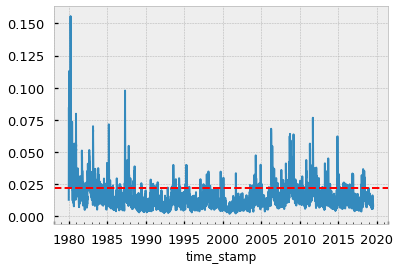

In [471]:
f,ax=plt.subplots()
monVol.plot(ax=ax)
ax.axhline(daily_Vol.mean(),ls='--',color='r')

In [472]:
h=daily_Vol.mean()

In [474]:
# tEvents to find the time at which A vertical Side can be kept for Triple barrier
tEvents = getTEvents(close,h=h)

t1 = addVerticalBarrier(tEvents, close, numDays=1)



  0%|          | 0/14445 [00:00<?, ?it/s]

 10%|▉         | 1413/14445 [00:00<00:00, 14122.81it/s]

 20%|█▉        | 2859/14445 [00:00<00:00, 14219.87it/s]

 30%|███       | 4345/14445 [00:00<00:00, 14404.12it/s]

 41%|████      | 5863/14445 [00:00<00:00, 14626.34it/s]

 51%|█████     | 7402/14445 [00:00<00:00, 14844.93it/s]

 61%|██████    | 8822/14445 [00:00<00:00, 14642.84it/s]

 71%|███████   | 10242/14445 [00:00<00:00, 14505.88it/s]

 81%|████████▏ | 11756/14445 [00:00<00:00, 14688.53it/s]

 91%|█████████ | 13146/14445 [00:00<00:00, 14044.91it/s]

100%|██████████| 14445/14445 [00:01<00:00, 14235.47it/s]

In [475]:
ptsl = [1,1]
target=monVol
# select minRet
minRet = 0.04 # 3% return
cpus = 1
events = getEvents(close,tEvents,ptsl,target,minRet,cpus,t1=t1)

In [477]:
labels = getBins(events, close)
#print(labels.bin.value_counts())

In [478]:
clean_labels = dropLabels(labels)

In [479]:
def getBinsNew(events, close, t1=None):
    '''
    Compute event's outcome (including side information, if provided).
    events is a DataFrame where:
    -events.index is event's starttime
    -events['t1'] is event's endtime
    -events['trgt'] is event's target
    -events['side'] (optional) implies the algo's position side
    -t1 is original vertical barrier series
    Case 1: ('side' not in events): bin in (-1,1) <-label by price action
    Case 2: ('side' in events): bin in (0,1) <-label by pnl (meta-labeling)
    '''
    #1) prices aligned with events
    events_=events.dropna(subset=['t1'])
    px=events_.index.union(events_['t1'].values).drop_duplicates()
    px=close.reindex(px,method='bfill')
    #2) create out object
    out=pd.DataFrame(index=events_.index)
    out['ret']=px.loc[events_['t1'].values].values/px.loc[events_.index]-1
    if 'side' in events_:out['ret']*=events_['side'] # meta-labeling
    out['bin']=np.sign(out['ret'])
    
    if 'side' not in events_:
        # only applies when not meta-labeling
        # to update bin to 0 when vertical barrier is touched, we need the original
        # vertical barrier series since the events['t1'] is the time of first 
        # touch of any barrier and not the vertical barrier specifically. 
        # The index of the intersection of the vertical barrier values and the 
        # events['t1'] values indicate which bin labels needs to be turned to 0
        vtouch_first_idx = events[events['t1'].isin(t1.values)].index
        out.loc[vtouch_first_idx, 'bin'] = 0.
    
    if 'side' in events_:out.loc[out['ret']<=0,'bin']=0 # meta-labeling
    return out

In [480]:
fast_window = 3
slow_window = 7

close_df = (pd.DataFrame()
            .assign(price=close)
            .assign(fast=close.ewm(fast_window).mean())
            .assign(slow=close.ewm(slow_window).mean()))
#cprint(close_df)

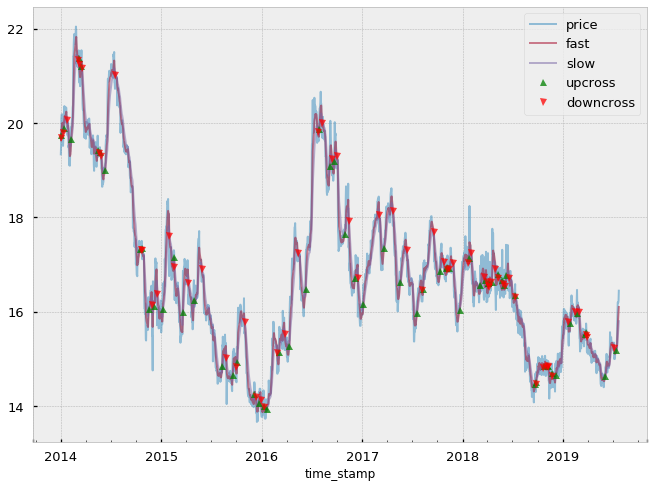

In [481]:
def get_up_cross(df):
    crit1 = df.fast.shift(1) < df.slow.shift(1)
    crit2 = df.fast > df.slow
    return df.fast[(crit1) & (crit2)]

def get_down_cross(df):
    crit1 = df.fast.shift(1) > df.slow.shift(1)
    crit2 = df.fast < df.slow
    return df.fast[(crit1) & (crit2)]

up = get_up_cross(close_df)
down = get_down_cross(close_df)

f, ax = plt.subplots(figsize=(11,8))

close_df.loc['2014':].plot(ax=ax, alpha=.5)
up.loc['2014':].plot(ax=ax,ls='',marker='^', markersize=7,
                     alpha=0.75, label='upcross', color='g')
down.loc['2014':].plot(ax=ax,ls='',marker='v', markersize=7, 
                       alpha=0.75, label='downcross', color='r')

ax.legend()

In [482]:
side_up = pd.Series(1, index=up.index)
side_down = pd.Series(-1, index=down.index)
side = pd.concat([side_up,side_down]).sort_index()
#cprint(side)

In [483]:
minRet = 0.01
ptsl=[1,2]

monVol = (close_df['price']/close_df['price'].shift(1)-1).ewm(span=10).std()
tEvents = getTEvents(close_df['price'],h=monVol.mean())
t1 = addVerticalBarrier(tEvents, close_df['price'], numDays=1)

ma_events = getEvents(close_df['price'],tEvents,ptsl,target,minRet,cpus,
                      t1=t1,side=side)


ma_events.side.value_counts()
ma_side = ma_events.dropna().side
ma_bins = getBinsNew(ma_events,close_df['price'], t1).dropna()
labelling = pd.merge_asof(ma_bins, side.to_frame().rename(columns={0:'side'}),
                   left_index=True, right_index=True, direction='forward')




  0%|          | 0/14445 [00:00<?, ?it/s]

 10%|▉         | 1416/14445 [00:00<00:00, 14156.87it/s]

 20%|█▉        | 2877/14445 [00:00<00:00, 14288.03it/s]

 30%|███       | 4380/14445 [00:00<00:00, 14502.02it/s]

 41%|████      | 5868/14445 [00:00<00:00, 14613.29it/s]

 51%|█████     | 7348/14445 [00:00<00:00, 14667.46it/s]

 61%|██████    | 8847/14445 [00:00<00:00, 14762.23it/s]

 72%|███████▏  | 10338/14445 [00:00<00:00, 14803.95it/s]

 82%|████████▏ | 11822/14445 [00:00<00:00, 14813.86it/s]

 92%|█████████▏| 13308/14445 [00:00<00:00, 14826.17it/s]

100%|██████████| 14445/14445 [00:00<00:00, 14615.71it/s]